In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import multianalysis as ma

### A lot to do still

# Formula Networks

This notebook will cover the explorative studies into making networks from a list of formulas. Each formula will represent a node. Nodes will be connected if their respective formulas can be interconverted by a simple chemical reaction (enzymatic or non-enzymatic) that are represented by shifts in the elemental composition of the formula. For example, a methylation would correspond to adding a CH2 group to the formula.

### Groups to Consider

One of the most critical questions of this endeavour is which groups to consider to represent the different possible simple chemical reactions. Ideally, they should cover most common enzymatic and non-enzymatic reactions while also being a relatively small amount of reactions. The first iteration of this attempt consider 14 different groups. Of those, 8 remain among the 16 now considered.

- CH2 (methylation) EC 2.1.1
- OH (hydroxylation) when? Does SH too? OH only when other things leave I think
- O (oxygenation) EC1?
- H2 (Hydrogenation) EC1?
- O(-NH) (Aminase) instead of NH2? (NH3(-O) - H2) EC3.5 EC6.3
- PO3H (phosphorylation) EC2.7 
- NH3(-O) (transaminases)  EC2.6.1
- SO3 (sulphation) EC2.8.2
- CO (things like formylation) EC2.1.2
- CO2 (carboxylation, decarboxylation) EC2.1.3 EC4 (CO+O) 
- CHOH (Hydroxymethylation) EC2.1.2 (CH2 + O)
- NCH (formidoyltransferase) EC2.1.2.4/5
- CONH (carbamoyltransferase) EC2.1.3 (NCH + O)
- C2H2O (acetylation) EC2.3 (CO+CH2)
- S EC2.8.1 somewhat rare but we need more S reactions
- H2O (cyclizations like in 3.5.2?) (H2 + O)


#NH2 when? Take out and let O(-NH) stay?
#PH2

##### Extra group transfers found that could be used maybe? 

- CN2H2 Amidinotransferases  EC.2.1.4 (only 2 enzymes)
- Transketolases and transaldolases EC2.2
- Most acyltransferases EC2.3
- COCH2COO (malonyl) - too big? EC2.3
- EC2.4 GLycosyltransferases - too big
- EC2.5 alkyl and aryl groups bigger than methyl - dimethylalyl best candidate to include - 
- EC 2.6.3.1 JUst one enzyme NH
- Some of the later EC2.7 have groups connected to the phosphate
- S2O2 not worth
- Nitrile Hydrolase (H202(-N))

### Extensions made

Since the overall idea mentioned was generating massively underconnected networks despite the 14 groups used (originally) to establish the network, an extension to the concept was applied to generate more connected networks that could be more reliably analysed.

The extension took into account the possibility of "missing links". That is, a metabolite in chain of a certain group could be missing so we try to add multiple of said groups to see if there are further elements in the chain. This was done until a maximum of 5 groups away. Of course, the more multiples of a group needed to connect to another formula, the weaker said connection is. This was represented by the attribute weight where a value of 1 was added to the weight for each extra multiple added.

For example, imagine the node C10H20O6. Testing a connection with the CH2 group, we try to find the node C11H22O6. If it doesn't exist, we can see if it's a missing link in the chain and search for the node further on in the chain with 2 more CH2 groups that C10H20O6, that is, the node C12H2406, then C13H26O6, until a maximum of 5 more CH2 groups in relation to the original node. Imagine C12H24O6 doesn't exist, but the node C13H26O6 exists. So the node is connected to C10H20O6 but with the weight/distance of 3 instead of the normal 1, since the distance between the nodes is equal to 3 CH2 groups.

### Reading the files

So before anything else, we will have to read the files for the datasets we are going to use. The main dataset that we will use will be the yeast dataset that we will read somewhat similarly to yeast_new notebook although slightly different since we don't need so many modifications. 

We will also have the grapevine dataset on standby if we want to experiment with it.

#### Reading Yeast dataset

Most of this was taken from the yeast_new notebook.

File and formulas given by the MetaboScape software.

In [2]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    data = data.sort_values(by = 'm/z')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    # peak_cols = ['m/z', 'Name', 'Formula']
    # intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    # peaks = data[peak_cols]
    # intensities = data[intensity_cols]

    # replace zeros for NaN's
    #intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    #peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        data = mtl.add_labels(data, labels=add_labels)
    
    return data

In [3]:
def renamer(colname):
    # Useful to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da'

labels = 'Metadata BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

In [4]:
# Read in the two files and keep results in dicts 
prefix_to_drop = None # change to 'ENO' to remove ENO strain

yeast_data = reading_MetScape_file('5yeasts_notnorm_2.csv', 
                                       remove_ref_feat=None,
                                       add_labels=None,
                                       col_renamer=renamer,
                                       prefix_to_drop=None)
yeast_data

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,3945019.75,3852594.00,3821208.250,4.204017e+06,4131124.25,4.059027e+06,4.352161e+06,4440771.000,4499343.500,4.345543e+06,4.091804e+06,4.545699e+06,4.248517e+06,4.207834e+06,4.208490e+06
201.1729328725 Da,202.18021,NaN,C11H23NO2,3404298.50,3366785.00,3348790.750,3.672346e+06,3737722.00,3.793184e+06,3.923927e+06,3804580.500,3801558.250,3.835366e+06,3.708862e+06,3.889770e+06,3.635306e+06,3.618243e+06,3.543283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [5]:
def feature_filter(Spectra):
    """Join all features that share the same formula by simple addition.
       
       Spectra: AlignedSpectra object (from metabolinks).
       
       Returns: Aligned Spectra object (from metabolinks) with filtered dataset.
    """
    df = Spectra
    #Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    #Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: #If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else:
            if form_count[i] > 1: #If the formula appears more than one time in the dataset
                if i not in rep: #And If it didn't already appear before
                    #Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    #same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:3]
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 0) #Addition of all m/z peaks intensity
                    newrow_c = pd.concat([info, newrow], axis = 0)
                    #m/z peak stays is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    #Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) #Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else:
                rp = rp.append(df.iloc[a,:]) #Append peaks with formulas that aren't repeated in the dataset
        a = a + 1
    #return dataframe in AlignedSpectra format.
    return rp

In [6]:
yeast_df = yeast_data.dropna(subset = ['Formula'])
yeast_df = feature_filter(yeast_df)
yeast_df = yeast_df[yeast_df.iloc[:,0] < 800]

In [7]:
yeast_df

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.000000e+00,0.000000e+00,0.000000e+00,5.524132e+05,6.483882e+05,6.080372e+05,6.375496e+05,610135.875,6.566536e+05,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,7.349318e+06,7.219379e+06,7.169999e+06,7.876362e+06,7.868846e+06,7.852211e+06,8.276088e+06,8245351.500,8.300902e+06,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.9791043208 Da,202.98638,NaN,C4H10O3S3,5.979574e+05,0.000000e+00,5.714457e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
203.1156661180 Da,204.12294,L-Acetylcarnitine,C9H17NO4,9.080770e+06,8.507996e+06,8.790471e+06,1.306664e+07,1.276478e+07,1.262020e+07,4.052399e+06,4071939.375,3.710998e+06,5.500948e+06,5.500034e+06,5.690336e+06,5.576097e+06,5.274222e+06,5.336592e+06
203.1268992141 Da,204.13418,Glycyl-Lysine,C8H17N3O3,1.552573e+06,1.624512e+06,1.601379e+06,2.134372e+06,2.044589e+06,1.159726e+06,2.132446e+06,2235339.375,1.278033e+06,6.275618e+05,5.937806e+05,6.216861e+05,2.329378e+06,2.365200e+06,2.431183e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798.8788514105 Da,799.88613,NaN,C13H18N15O6PS9,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,5.856792e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
798.8962674883 Da,799.90354,NaN,C21H30N5O4PS11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.968262e+05
798.9297232833 Da,799.93700,NaN,C23H33N3O6S11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.810934e+05
798.9532830862 Da,799.96056,NaN,C44H17NO3S6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.571149e+05,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


#### Reading a sample from Grapevine dataset (in case of necessity)

File and formulas from the Formularity sofware (free formula assigning software)

In [8]:
#CAN file with parameters: N+S+P Formula score, 1 ppm, 800 limit database
#Gv_CAN1 = pd.read_csv('Formularity_data/CAN_NSP_1_800.csv')
#Gv_CAN1[Gv_CAN1['El_comp'].notnull()]

### Functions to change how each formula is represented

On the dataset, each formula is represented as a string with the following structure: 'CxHxNxOxPxSx' where x is the number of each element. If x=1, it is absent; if x=0, the element itself won't appear in the formula.

The objective of the following function is to transform all formulas into a dataframe where each element will be represented by a column with the names 'C','H','O','N','S','P' while each "string" formatted formula will be the index of each row.

The main function is called deformulator since we are de-construting the formulas format.

In [9]:
def deformulator(df):
    """Transforms a set of formulas in string format into a DataFrame with columns corresponding to each element.
       Element order: C, H, N, O, S, P, F, Cl.
    """
    
    filtered_formulas = df['Formula'].dropna() #Dropping empty cells (without formulas)
    formulas = pd.DataFrame(np.zeros((len(filtered_formulas),6)), index = filtered_formulas.index,
                            columns = ['C','H','O','N','S','P']) #Making a blank Dataframe that will store the formulas
    
    for i in filtered_formulas:
        if 'C(13)' in i:
            #Drops C(13) formulas - the C12 formulas already exist
            formulas = formulas.drop(filtered_formulas[filtered_formulas == i].index)
        else:
            #Transform the string representing the formula into the Dataframe
            formulas.loc[filtered_formulas[filtered_formulas == i].index[0]] = formula_process(i).iloc[0]
            
    return formulas

In [10]:
def formula_process(formula):
    """Transforms a formula in string format into a DataFrame. Element order: C, H, N, O, S, P, F, Cl."""
    
    #Make the row DataFrame to store the results
    results = pd.DataFrame(np.zeros((1,6)), columns = ['C','H','O','N','S','P'])
    count = ''
    letter = None
    
    #Run through the string
    for i in formula:
        if not letter: #See the current letter
            letter = i
        else:
            try: #if it's a number, int(i) works and it is stored in count (for numbers that are bigger than 9)
                int(i)
                count += i
            except ValueError: #if it's not a number and int doesn't work, store the number of the letter on the right columns
                results[letter] = int(count or 1) #If it's 1, count would be empty
                letter = i #Replace the current letter and reset the count
                count = ''
    
    #Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

## Example of Building a Network for a single sample

Sample chosen: Replicate nº 2 of the yeast strain BY

First, select the formulas that appear in that sample and use deformulator to get the needed dataframe.

In [11]:
BY2 = yeast_df[yeast_df.iloc[:,4] != 0]
formula_df = deformulator(BY2)
formula_df.index = BY2['Formula'] #The string format formulas become the index
formula_df

,C,H,O,N,S,P
Formula,,,,,,
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0
C7H12N2O5,7.0,12.0,5.0,2.0,0.0,0.0
C6H10N2S3,6.0,10.0,0.0,2.0,3.0,0.0
...,...,...,...,...,...,...
C37H70N2O10P2S,37.0,70.0,10.0,2.0,1.0,2.0
C44H92OS5,44.0,92.0,1.0,0.0,5.0,0.0
C48H31NO5S3,48.0,31.0,5.0,1.0,3.0,0.0


Now we have a dataframe where each column represents a columns which will be filled in each with the number of that element in the formula that represents the row.

Now we have to form a graph and establish connections between the formulas.

### Functions for Graph building

Here we put the  functions we will need to build the different graphs, to add edges and edge attributes.

- edge_finder: searches for a specific edge between the selected node and all the other nodes for one of the simple chemical reactions.
- edge_assembler: performs all possible connections (with all the groups chosen) in the network by applying in succession edge_finder to each pair of node and chemical reaction. It also returns a dictionary with a measure of the number of times a chemical reaction was used to connect different nodes with connections "far away" contributing with the inverse of their weight.
- inverse_weight_attributer: gives and edge attribute to the graph that is the inverse of the weight of each edge to use with the weighted degree to give less important to connections "far away".

In [12]:
def edge_finder(G, df, node, c=0, h=0, o=0, n=0, s=0, p=0, depth=5):
    """Creates edges in a network between different formulas with specific elemental differences.
    
       G: networkX graph object; graph where edges will be added
       df: Pandas DataFrame; dataframe with information about the formulas representing each node
       node: Pandas Series/row of a DataFrame; specific node which will be connected with other similar nodes (row from the
    above DataFrame)
       c,h,o,n,s,p: int's; integers representing the difference each element (C,H,O,N,S,P respectively) should have between
    2 formulas to connect them with an edge
       depth: int; number of possible 'missing links' between the 2 formulas accepted (weight of the node will be equal to the
    depth)
    
       returns: a row of a DataFrame that represents the other node of the edge created (if possible)."""
    
    #See if there is a formula with the specified difference in relation to the chosen node
    choose = formula_df[formula_df['C'] == node['C'] + c]
    choose = choose[choose['H'] == node['H'] + h]
    choose = choose[choose['O'] == node['O'] + o]
    choose = choose[choose['N'] == node['N'] + n]
    choose = choose[choose['S'] == node['S'] + s]
    choose = choose[choose['P'] == node['P'] + p]
    
    if len(choose) > 0: #If a node was found
        G.add_edge(node.name,choose.index[0], weight = 1)
        return 1 #The weight
    
    else:
        for j in range(2, depth+1):
            #See if there is a formula with j times the specified difference in relation to the chosen node
            #This is performed from 2 until the maximum depth given
            choose = formula_df[formula_df['C'] == node['C'] + j*c]
            choose = choose[choose['H'] == node['H'] + j*h]
            choose = choose[choose['O'] == node['O'] + j*o]
            choose = choose[choose['N'] == node['N'] + j*n]
            choose = choose[choose['S'] == node['S'] + j*s]
            choose = choose[choose['P'] == node['P'] + j*p]
            
            #End the function if a node is found
            if len(choose) > 0:
                G.add_edge(node.name,choose.index[0], weight = j)
                return j #The weight
    
    return 0 #No other node was found to connect the given node to

In [13]:
def edge_assembler(formula_df, G):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges."""
    
    groups = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
    group_influence = dict.fromkeys(groups,0)
    
    #For each possible node in the dataframe, try to find all connections to it
    for i in formula_df.index:
        node = formula_df.loc[i]
        
        #H2
        weight = edge_finder(G, formula_df, node, h=2)
        #print(weight)
        if weight != 0:
            group_influence['H2'] = group_influence['H2'] + (1/weight)

        #CH2
        weight = edge_finder(G, formula_df, node, c=1, h=2)
        if weight != 0:
            group_influence['CH2'] = group_influence['CH2'] + (1/weight)

        ######CO2
        weight = edge_finder(G, formula_df, node, c=1, o=2)
        if weight != 0:
            group_influence['CO2'] = group_influence['CO2'] + (1/weight)

        #O
        weight = edge_finder(G, formula_df, node, o=1)
        if weight != 0:
            group_influence['O'] = group_influence['O'] + (1/weight)

        ######CHOH
        weight = edge_finder(G, formula_df, node, c=1, h=2, o=1)
        if weight != 0:
            group_influence['CHOH'] = group_influence['CHOH'] + (1/weight)

        ######NCH
        weight = edge_finder(G, formula_df, node, c=1, h=1, n=1)
        if weight != 0:
            group_influence['NCH'] = group_influence['NCH'] + (1/weight)

        #O(-NH)
        weight = edge_finder(G, formula_df, node, h=-1, o=1, n=-1)
        if weight != 0:
            group_influence['O(-NH)'] = group_influence['O(-NH)'] + (1/weight)

        #OH
        weight = edge_finder(G, formula_df, node, h=1, o=1)
        if weight != 0:
            group_influence['OH'] = group_influence['OH'] + (1/weight)

        #S
        weight = edge_finder(G, formula_df, node, h=1, s=1)
        if weight != 0:
            group_influence['S'] = group_influence['S'] + (1/weight)

        #CONH
        weight = edge_finder(G, formula_df, node, h=2, p=1)
        if weight != 0:
            group_influence['CONH'] = group_influence['CONH'] + (1/weight)
    
        #PO3(H)
        weight = edge_finder(G, formula_df, node, h=1, o=3, p=1)
        if weight != 0:
            group_influence['PO3H'] = group_influence['PO3H'] + (1/weight)

        #NH3-O
        weight = edge_finder(G, formula_df, node, h=3, o=-1, n=1)
        if weight != 0:
            group_influence['NH3(-O)'] = group_influence['NH3(-O)'] + (1/weight)

        #SO3
        weight = edge_finder(G, formula_df, node, h=0, o=3, s=1)
        if weight != 0:
            group_influence['SO3'] = group_influence['SO3'] + (1/weight)

        #CO
        weight = edge_finder(G, formula_df, node, c=1, o=1)
        if weight != 0:
            group_influence['CO'] = group_influence['CO'] + (1/weight)
            
        #C2H2O
        weight = edge_finder(G, formula_df, node, c=2, h=2, o=1)
        if weight != 0:
            group_influence['C2H2O'] = group_influence['C2H2O'] + (1/weight)
        
        #H2O
        weight = edge_finder(G, formula_df, node, h=2, o=1)
        if weight != 0:
            group_influence['H2O'] = group_influence['H2O'] + (1/weight)
                
    return group_influence

In [14]:
def inverse_weight_attributer (graph):
    """Adds an inverse weight attribute to the edges to do a specific degree count."""
    
    wei = {}
    for i in graph.edges.data('weight'):
        wei[(i[0], i[1])] = 1/i[2]
    nx.set_edge_attributes(graph, wei, 'weight_inv')

### Building a graph

First, we set up the graph Gr using the module NetworkX that will be mainly using from now on and add all the formulas as different nodes in the graph.

Then we use the edge_assembler function to establish all the edges in the network and return a dictionary of the influence of each chemical group (representing types of chemical reactions) in establishing the edges in said network (slow) and the inverse_weight_attributer to add another edge attribute which will be useful later. 

In [15]:
Gr = nx.Graph()
Gr.add_nodes_from(formula_df.index)

In [16]:
BY2_groups = edge_assembler(formula_df,Gr)
inverse_weight_attributer(Gr)

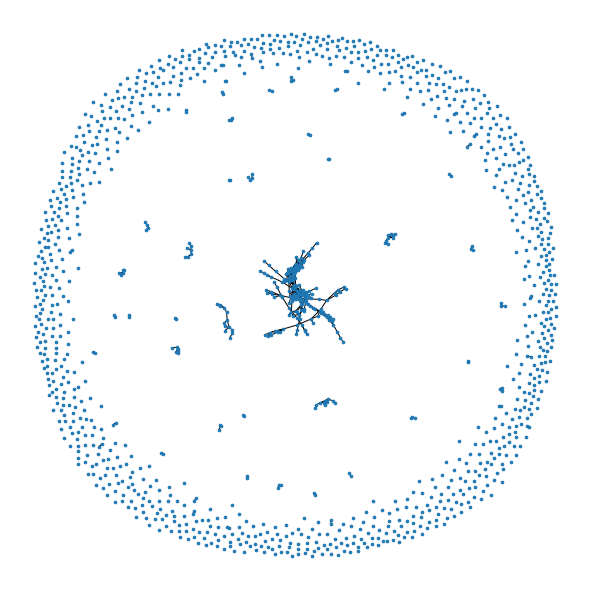

In [17]:
plt.figure(figsize=(8,8))
nx.draw(Gr, node_size=7)
plt.show()

In [18]:
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[139, 31, 13, 10, 9, 9, 7, 6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2]

In [19]:
BY2_groups

{'H2': 41.03333333333333,
 'CH2': 85.23333333333333,
 'CO2': 18.5,
 'O': 46.60000000000001,
 'CHOH': 37.666666666666664,
 'NCH': 13.399999999999999,
 'O(-NH)': 9.7,
 'OH': 8.25,
 'S': 0,
 'CONH': 0,
 'PO3H': 16.0,
 'NH3(-O)': 10.0,
 'SO3': 3.0,
 'CO': 26.866666666666667,
 'C2H2O': 19.666666666666664,
 'H2O': 31.033333333333335}

#### Some conclusions:

Seems like the 'S' and the 'CONH' group aren't being very useful to establish connections. 'SO3' also doesn't seem very useful, which is surprising since adding a SO3 group should be a somewhat "common" reaction. These conclusions can be more easily taken by analysing the full possible yeast dataset - end of the notebook.

In [20]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

366.95000000000005

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality. The last two use the weights of the different edges and degree uses the inverse of the weight as given by the function inverse_weight_attributer.

In [21]:
nx.degree(Gr)
G_degree = dict(Gr.degree(weight='weight_inv'))
G_degree_all = sorted(G_degree.items(), key=lambda kv: kv[1], reverse = True)
G_degree_all[:20]

[('C18H34O3', 10.5),
 ('C18H34O4', 8.833333333333332),
 ('C16H30O2', 8.5),
 ('C16H30O3', 8.5),
 ('C17H34O2', 7.5),
 ('C23H45NO4', 7.5),
 ('C16H32O2', 7.0),
 ('C22H43NO3', 7.0),
 ('C18H34O2', 6.5),
 ('C19H36O3', 6.5),
 ('C22H41NO2', 6.5),
 ('C22H43NO4', 6.5),
 ('C18H37NO3', 6.333333333333334),
 ('C22H43NO2', 6.333333333333333),
 ('C18H32O3', 6.033333333333333),
 ('C17H32O2', 6.0),
 ('C19H36O4', 6.0),
 ('C22H45NO3', 6.0),
 ('C18H36O2', 5.5),
 ('C23H47NO4', 5.5)]

In [22]:
G_betw = nx.betweenness_centrality(Gr, weight = 'weight')
G_betw_all = sorted(G_betw.items(), key=lambda kv: kv[1], reverse = True)
G_betw_all[:20]

[('C18H37NO3', 0.00259512591502494),
 ('C21H42O4', 0.0024027294653170108),
 ('C22H43NO4', 0.0022682891746122176),
 ('C22H46O6', 0.002079564373273397),
 ('C21H44O5', 0.0020656706206564324),
 ('C18H34O4', 0.0020166122047590835),
 ('C20H41NO3', 0.0015168130361580157),
 ('C23H48O6', 0.0013850091046931504),
 ('C18H38NO6P', 0.0013474680041295523),
 ('C23H45NO4', 0.0013384625064890082),
 ('C18H32O3', 0.001106258506969081),
 ('C16H30O2', 0.0010915476183358409),
 ('C18H34O3', 0.0010460663747541591),
 ('C16H32O2', 0.0010146034278639318),
 ('C14H28O2', 0.0009787172227899352),
 ('C22H44NO7P', 0.0008868598889678595),
 ('C23H47NO4', 0.0008546625110149343),
 ('C13H26O2', 0.0008397773382388146),
 ('C16H28O', 0.000834159601612609),
 ('C25H52O7', 0.0007625644928602362)]

In [23]:
G_closeness = nx.closeness_centrality(Gr, distance = 'weight')
G_closeness_all = sorted(G_closeness.items(), key=lambda kv: kv[1], reverse = True)
G_closeness_all[:20]

[('C18H37NO3', 0.018276602033804615),
 ('C18H34O4', 0.01818417926751483),
 ('C18H34O3', 0.017498401217280083),
 ('C19H36O4', 0.017498401217280083),
 ('C20H41NO3', 0.017477139490406114),
 ('C18H32O3', 0.01726732989268215),
 ('C22H43NO4', 0.017225971018687704),
 ('C17H34O2', 0.017205365790196447),
 ('C18H37NO2', 0.01710307467372679),
 ('C19H36O3', 0.01708276223349671),
 ('C17H34O3', 0.01700199267210902),
 ('C18H36O2', 0.016981919481232857),
 ('C19H38O4', 0.016981919481232857),
 ('C21H42O4', 0.016921983294828507),
 ('C18H34O2', 0.016764202564806794),
 ('C21H40O3', 0.01672521604721422),
 ('C19H38O2', 0.016667075087606294),
 ('C18H38NO6P', 0.01660933695219888),
 ('C16H32O2', 0.016532972184602566),
 ('C18H35NO', 0.01651399058622759)]

## Formula Network Analysis

### Building the formula network for each sample and gathering the main results from each network

edge_assembler function is slow

In [24]:
#Making all the graphs and taking out centrality measures
G = {}
G_degree = {}
G_betw = {}
G_closeness = {}
G_degree_20 = {}
G_betw_20 = {}
G_closeness_20 = {}
G_groups = {}
G_components = {}

for j in yeast_df.columns[3:]:
    df = yeast_df[yeast_df.loc[:,j] != 0]
    formula_df = deformulator(df)
    formula_df.index = df['Formula']
    G[j] = nx.Graph()
    G[j].add_nodes_from(formula_df.index)
    G_groups[j] = edge_assembler(formula_df, G[j])
    inverse_weight_attributer(G[j]) #Adding the edge 
    
    print(j, 'is done')

BY0_1 is done
BY0_2 is done
BY0_3 is done
GRE3_1 is done
GRE3_2 is done
GRE3_3 is done
ENO1_1 is done
ENO1_2 is done
ENO1_3 is done
dGLO1_1 is done
dGLO1_2 is done
dGLO1_3 is done
GLO2_1 is done
GLO2_2 is done
GLO2_3 is done


In [25]:
#Storing the main centrality measures
for j in G:
    G_degree[j] = dict(G[j].degree(weight='weight_inv'))
    G_degree_20[j] = sorted(G_degree[j], key=G_degree[j].get, reverse = True)[:20]
    
    G_betw[j] = nx.betweenness_centrality(G[j], weight = 'weight')
    G_betw_20[j] = sorted(G_betw[j], key=G_betw[j].get, reverse = True)[:20]
    
    G_closeness[j] = nx.closeness_centrality(G[j], distance = 'weight')
    G_closeness_20[j] = sorted(G_closeness[j], key=G_closeness[j].get, reverse = True)[:20]
    
    G_components[j] = [len(c) for c in sorted(nx.connected_components(G[j]), key=len, reverse=True) if len(c) > 1]

### Centrality measures and Group Influence analysis

The analysis of each centrality measure is completely independent of each other.

Make a binary dataframe where the formulas that appear in at least the top 20 features in one of the samples in any of the centrality measures are the features. A sample has a value of 1 in a said feature if said feature is in it's top 20 formula with the highest value in the centrality measure that is being used for analysis and 0 if it isn't present.

After that normal binary similarity analysis is made as it was done in the similarity_analysis notebooks. Hierarchical Clustering (dendrograms), Random Forest and PLS-DA models to make predictive models and PLS-DA representation on the 2 main components is performed. 

In [26]:
#Making the dataframe for similarity comparisons
union_degree = ()
union_betw = ()
union_closeness = ()
for i in G_degree_20:
    union_degree = set(union_degree).union(G_degree_20[i])
    union_betw = set(union_betw).union(G_betw_20[i])
    union_closeness = set(union_closeness).union(G_closeness_20[i])
    
degree_df = pd.DataFrame(0, index = union_degree, columns = G_degree_20.keys())
betw_df = pd.DataFrame(0, index = union_betw, columns = G_betw_20.keys())
closeness_df = pd.DataFrame(0, index = union_closeness, columns = G_closeness_20.keys())

In [27]:
#Filling the Dataframe
for i in G_degree_20:
    for j in G_degree_20[i]:
        degree_df.loc[j,i] = 1

for i in G_betw_20:
    for j in G_betw_20[i]:
        betw_df.loc[j,i] = 1

for i in G_closeness_20:
    for j in G_closeness_20[i]:
        closeness_df.loc[j,i] = 1

Transform the dictionary of dictionaries with the Group Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "Group Influence" in this context?

Each group that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this group, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another). This was done in a similar way to the calculation of the degree for each individual node. Thus, each direct reaction with no "missing links" (edge weight = 1) adds one to the value of that group in the network and the "farther away" the two formulas are, a lower value will be added - 1/weight(edge).

This value then should represent the importance of the group in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that group in establishing the network. 

Here we test if the importance of these groups in establishing the overall network is characteristic of the strain of the sample.

In [28]:
groups_df = pd.DataFrame.from_dict(G_groups)#/pd.DataFrame.from_dict(G_groups).sum(axis=0)#.sum(axis=1)
groups_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,35.583333,41.033333,40.733333,44.366667,57.783333,57.116667,25.583333,34.250000,38.000000,42.000000,41.500000,45.250000,34.866667,31.516667,32.166667
CH2,76.866667,85.233333,86.150000,81.533333,100.233333,100.066667,50.650000,61.850000,64.983333,70.400000,78.016667,83.283333,69.150000,78.450000,88.150000
CO2,15.666667,18.500000,20.333333,20.666667,19.250000,23.833333,19.000000,21.000000,16.000000,17.500000,18.833333,19.750000,16.000000,20.333333,19.333333
O,40.383333,46.600000,47.083333,48.550000,52.266667,57.633333,25.516667,40.050000,38.100000,48.033333,50.133333,49.666667,37.633333,39.183333,46.116667
CHOH,34.033333,37.666667,37.500000,35.166667,43.000000,49.333333,17.000000,20.666667,24.833333,34.033333,34.833333,34.833333,25.916667,24.000000,26.833333
NCH,12.200000,13.400000,11.700000,8.583333,8.583333,7.333333,4.200000,10.533333,10.833333,7.583333,9.333333,9.083333,8.250000,4.600000,6.333333
O(-NH),11.400000,9.700000,9.666667,10.000000,12.333333,13.500000,5.950000,7.500000,6.450000,11.000000,9.450000,12.616667,5.700000,9.083333,7.583333
OH,8.000000,8.250000,9.250000,7.750000,11.000000,10.250000,5.000000,7.000000,6.000000,8.000000,8.000000,8.000000,5.750000,6.250000,5.250000
S,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.000000,0.500000,0.000000,0.000000,0.500000,0.500000,0.000000
CONH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

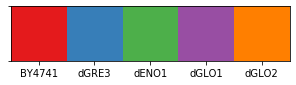

In [29]:
mtl.add_labels(degree_df, labels = labels)
mtl.add_labels(betw_df, labels = labels)
mtl.add_labels(closeness_df, labels = labels)
mtl.add_labels(groups_df, labels = labels)

sample_names = degree_df.cdl.samples
all_labels = degree_df.cdl.labels
unique_labels = degree_df.cdl.unique_labels

# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

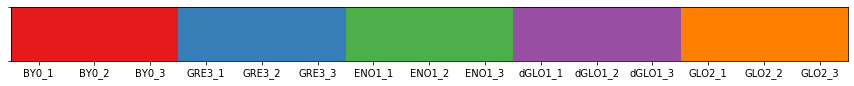

In [30]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

In [31]:
#Example of a dataframe
degree_df

label       BY4741              dGRE3                dENO1                \
             BY0_1 BY0_2 BY0_3 GRE3_1 GRE3_2 GRE3_3 ENO1_1 ENO1_2 ENO1_3   
C22H43NO4        1     1     1      0      0      0      0      0      0   
C14H27NO3        1     0     0      1      0      0      0      0      0   
C9H17O7P         0     0     0      1      0      1      0      0      0   
C17H34O3         0     0     1      0      0      0      0      1      1   
C19H36O3         1     1     1      0      0      1      1      1      1   
C18H32O3         0     1     1      1      1      0      1      1      1   
C18H34O2         1     1     1      1      0      1      1      1      1   
C22H45NO3        1     1     1      0      0      0      1      1      1   
C18H34O3         1     1     1      1      1      1      1      1      1   
C18H37NO2        0     0     0      0      0      1      0      0      0   
C18H28O5         0     0     0      1      0      0      1      0      1   
C23H45NO4        1     1     1      0      0      0      0      0      0   
C16H32O2         1     1     1      0      1      1      1      1      1   
C19H36O4         1     1     1      0      0      0      1      1      1   
C15H18O9S2       0     0     0      0      1      1      0      0      0   
C18H36O2         1     1     1      0      0      1      1      0      0   
C17H32O2         1     1     1      0      1      1      1      1      1   
C22H43NO2        0     1     1      0      0      0      0      1      1   
C13H25O9P        0     0     0      1      1      1      0      0      0   
C18H34O4         1     1     1      1      1      1      1      1      1   
C23H47NO4        0     1     0      0      0      0      0      0      0   
C14H16O8S2       0     0     0      0      1      0      0      0      0   
C16H28O          0     0     0      0      0      0      0      1      0   
C22H44NO7P       0     0     0      0      0      0      1      0      0   
C18H33NO5        0     0     0      1      1      1      0      0      0   
C16H30O3         0     1     1      0      1      1      0      1      1   
C18H33NO6        0     0     0      1      0      0      0      0      0   
C14H28O2         0     0     0      0      0      0      0      0      0   
C17H26O4         0     0     0      0      0      0      1      0      0   
C13H22O3         0     0     0      0      0      0      1      0      0   
C18H28O4         0     0     0      0      0      0      1      0      0   
C13H25O8P        0     0     0      1      0      0      0      0      0   
C18H37NO         0     0     0      0      0      0      0      0      0   
C19H34O3         0     0     0      0      0      0      0      0      0   
C13H23O8P        0     0     0      1      1      1      0      0      0   
C9H14N4O4        1     0     0      1      0      1      0      0      0   
C12H23O8P        0     0     0      1      1      1      0      0      0   
C16H30O4         0     0     0      0      1      1      0      0      0   
C16H26O          0     0     0      0      0      0      0      0      0   
C16H30O2         1     1     1      1      1      1      1      1      1   
C15H30O2         1     0     0      0      1      0      1      1      1   
C13H23O9P        0     0     0      1      1      0      0      0      0   
C17H32O3         1     0     0      0      1      1      0      1      1   
C17H34O2         1     1     1      1      1      1      1      1      1   
C11H19N3O7S      0     0     0      0      0      0      0      0      0   
C16H29NO5        0     0     0      1      1      0      0      0      0   
C12H23O7P        0     0     0      0      1      0      0      0      0   
C22H43NO3        1     1     1      0      0      0      0      1      1   
C13H25NO2        1     0     0      1      0      0      1      1      0   
C16H28O2         0     0     0      0      0      0      0      0      0   
C18H37NO3        1     1     1      0      0    

### Hierarchical Cluster Analysis (agglomerative)

In [32]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(14,7))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=12, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

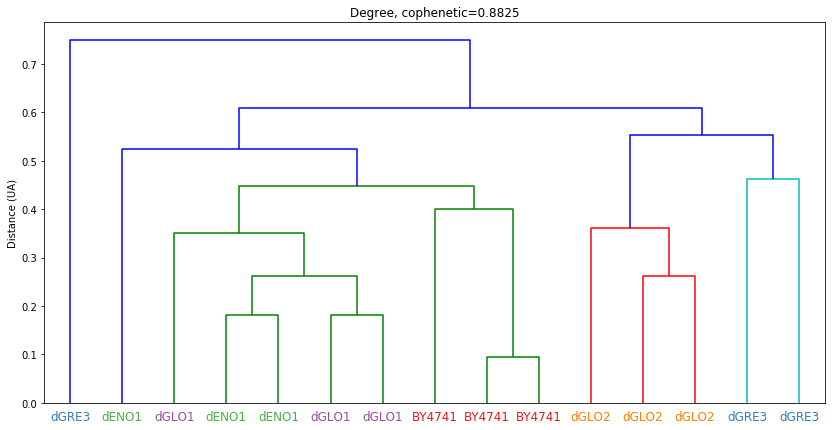

In [33]:
degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z = hier.linkage(degree_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, degree_df_jdist)[0] #method average seems to lead to higher coefficients

title = f'Degree, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

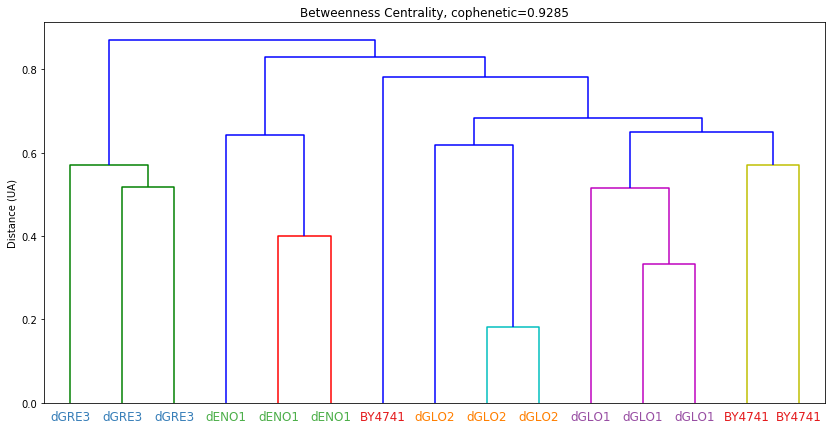

In [34]:
betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z = hier.linkage(betw_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, betw_df_jdist)[0] #method average seems to lead to higher coefficients

title = f'Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

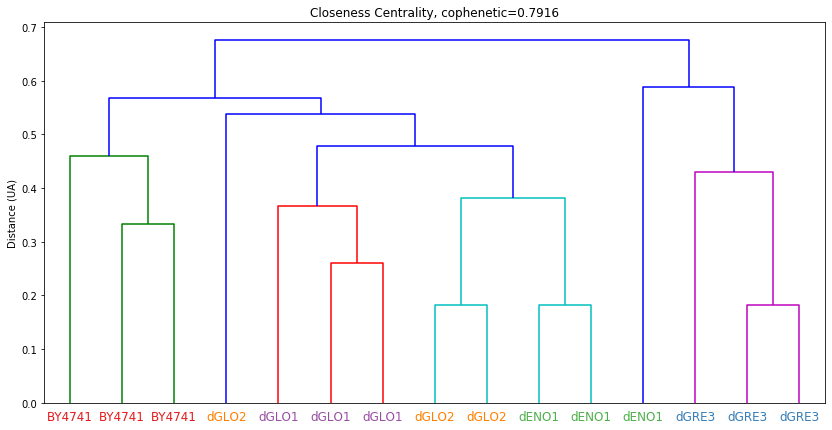

In [35]:
closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z = hier.linkage(closeness_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, closeness_df_jdist)[0] #method average seems to lead to higher coefficients

title = f'Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Summing all the distances between the different sample with the 3 centrality measures

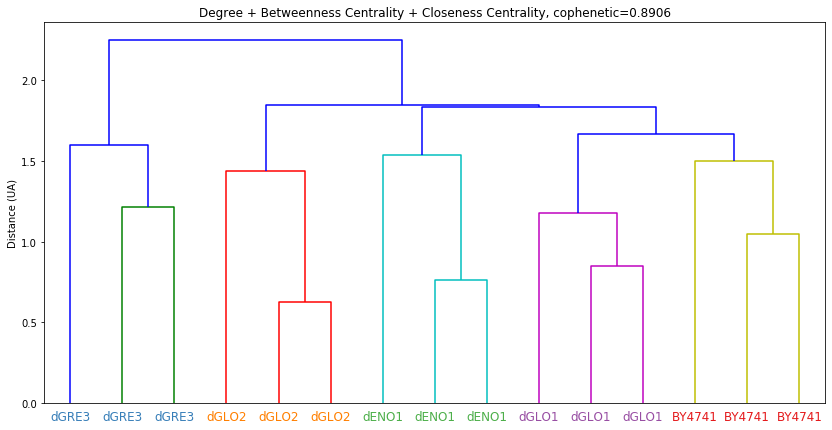

In [36]:
all_df_jdist = degree_df_jdist + betw_df_jdist + closeness_df_jdist
Z = hier.linkage(all_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, all_df_jdist)[0] #method average seems to lead to higher coefficients

title = f'Degree + Betweenness Centrality + Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Group Influence dendrogram

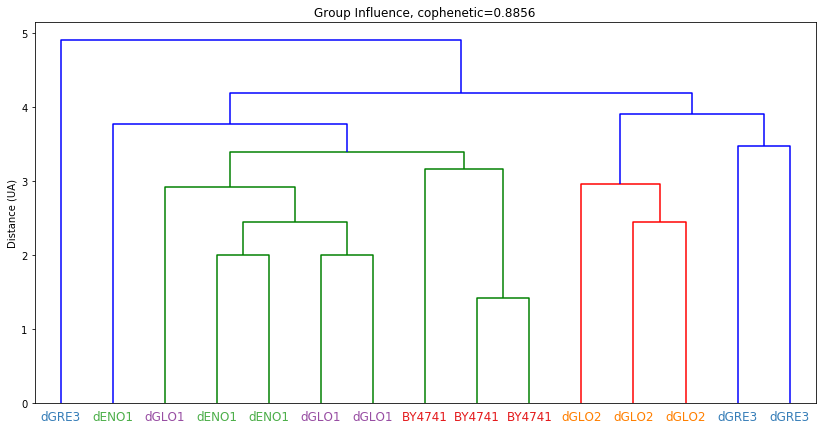

In [37]:
groups_df_dist = dist.pdist(degree_df.T, metric='euclidean')
Z = hier.linkage(groups_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, groups_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

### Random Forests

The datasets that will be analyzed

In [38]:
datasets = {'degree': degree_df, 'betweenness': betw_df, 'closeness' : closeness_df, 'groups': groups_df}

Application of the Random Forests

In [39]:
# Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)
    #, iter_num = 100) #(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for degree ...done
Fitting random forest for betweenness ...done
Fitting random forest for closeness ...done
Fitting random forest for groups ...done


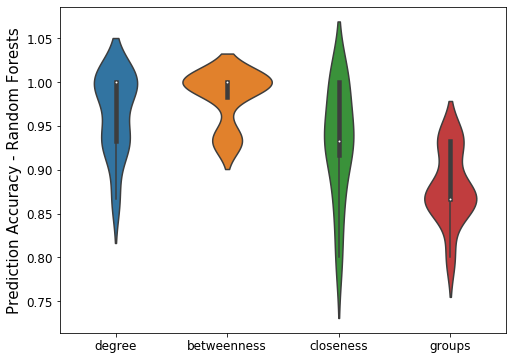

In [40]:
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores)
sns.violinplot(data = data,  alpha = 0.5) #palette = colors*2,
plt.ylabel('Prediction Accuracy - Random Forests', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)

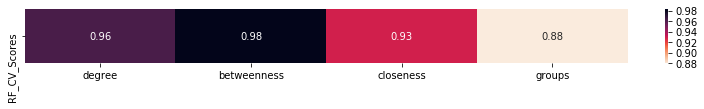

In [41]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [42]:
Imp_feat['groups']

[(10, 0.09969237151596745, 'PO3H'),
 (13, 0.08613147990949384, 'CO'),
 (0, 0.08010623383466003, 'H2'),
 (5, 0.07974784236346004, 'NCH'),
 (4, 0.07803457288738194, 'CHOH'),
 (3, 0.07338045195522956, 'O'),
 (14, 0.07324316738759588, 'C2H2O'),
 (11, 0.07008050488296372, 'NH3(-O)'),
 (15, 0.06615222981256567, 'H2O'),
 (6, 0.06531218096698352, 'O(-NH)'),
 (1, 0.06367923464446129, 'CH2'),
 (7, 0.06348976758652433, 'OH'),
 (2, 0.0450937242942709, 'CO2'),
 (12, 0.0375304703088927, 'SO3'),
 (8, 0.01832576764954907, 'S'),
 (9, 0.0, 'CONH')]

#### Extracting a single decision tree

Decision Tree


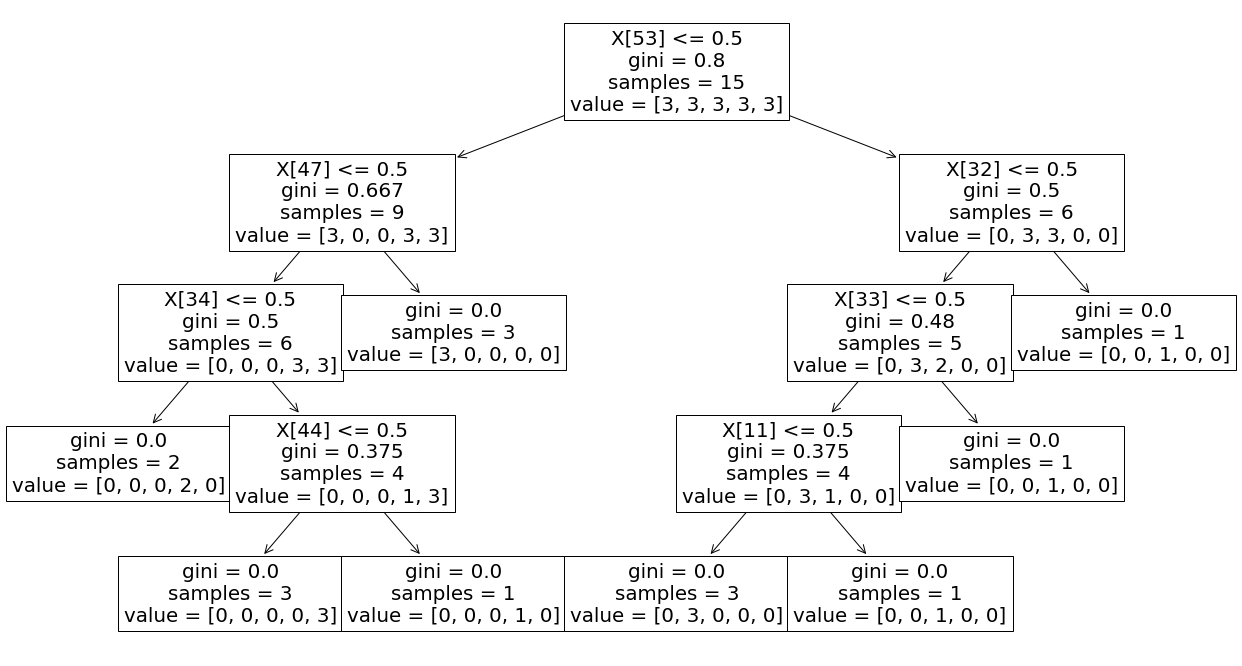

In [43]:
from sklearn.model_selection import train_test_split
import sklearn.ensemble as skensemble
X_train, X_test, y_train, y_test = train_test_split(datasets['degree'].T, all_labels, test_size=1/3)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
#rf.fit(X_train, y_train)
rf.fit(datasets['degree'].T, all_labels)

from sklearn import tree
fig = plt.figure(figsize=(22,12))
#clf = rf.estimators_[2].fit(X_train, y_train)
clf = rf.estimators_[2].fit(datasets['degree'].T, all_labels)
tree.plot_tree(clf)
print('Decision Tree')

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

All analysis is simialr to the ones performed in similarity_analysis notebooks

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [44]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


#### Search for the best number of components to use

In [45]:
%%capture --no-stdout
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for degree ...done
Optimizing PLS-DA for betweenness ...done
Optimizing PLS-DA for closeness ...done
Optimizing PLS-DA for groups ...done


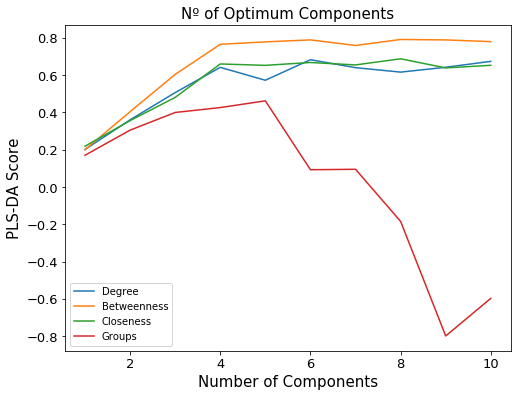

In [46]:
f, ax = plt.subplots(figsize=(8,6))


for name, data in PLS_optim.items():
    plt.plot(range(1,11),data)
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(('Degree', 'Betweenness', 'Closeness', 'Groups'))
plt.show()

#### Application of PLS-DA

In [47]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [48]:
%%capture --no-stdout

for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for degree ...done
Fitting PLS-DA for betweenness ...done
Fitting PLS-DA for closeness ...done
Fitting PLS-DA for groups ...done


Accuracy based on the dataset


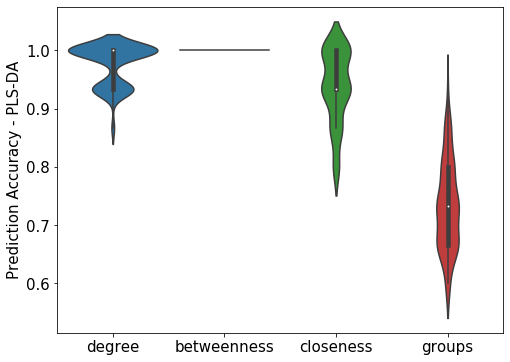

In [49]:
f, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), alpha = 0.5)#palette = colors, 
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset')

In [50]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

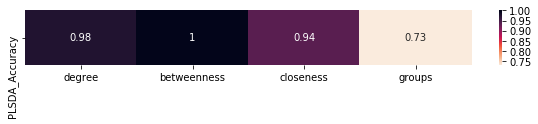

In [51]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [52]:
#PLS_feat

#### Model with the full dataset and sample representation on the two most important Components/Latent Variables

In [53]:
from sklearn.cross_decomposition import PLSRegression

In [54]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1, fontsize='large')
        ax.set_title(title, fontsize=15)

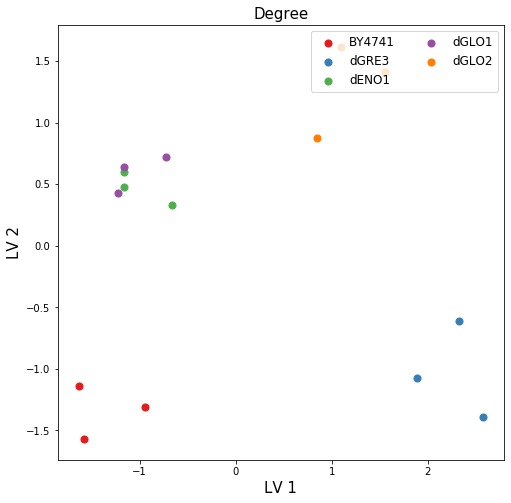

In [55]:
n_components = 5

plsreg = ma.PLSscores_with_labels(degree_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Degree", ax=axl)
plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.show()

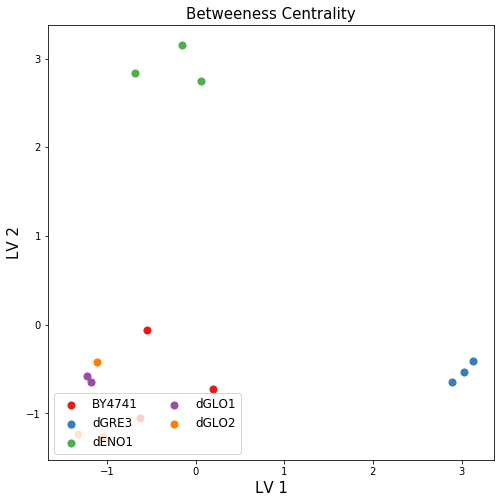

In [56]:
n_components = 5

plsreg = ma.PLSscores_with_labels(betw_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Betweeness Centrality", ax=axl)
plt.legend(loc='lower left', ncol=2, fontsize=12)
plt.show()

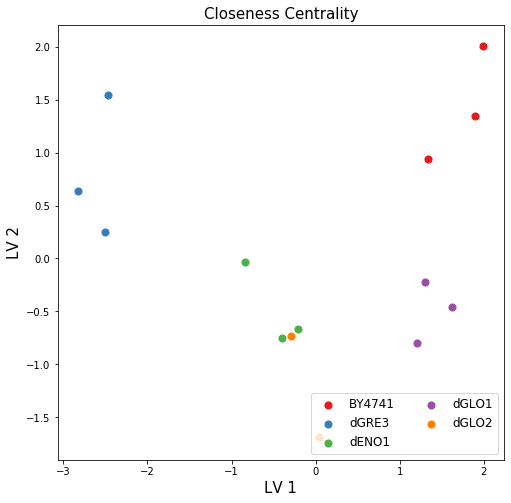

In [57]:
n_components = 5

plsreg = ma.PLSscores_with_labels(closeness_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Closeness Centrality", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

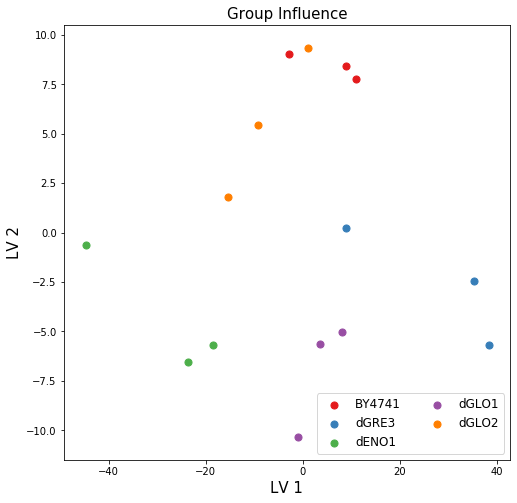

In [58]:
n_components = 2

plsreg = ma.PLSscores_with_labels(groups_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Group Influence", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

### Permutation Tests - PLS-DA

In [59]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (degree_df, betw_df, closeness_df)
names = ('Degree', 'Betweenness', 'Closeness')
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree ...
Done!
permutation test (PLS-DA) for Betweenness ...
Done!
permutation test (PLS-DA) for Closeness ...
Done!


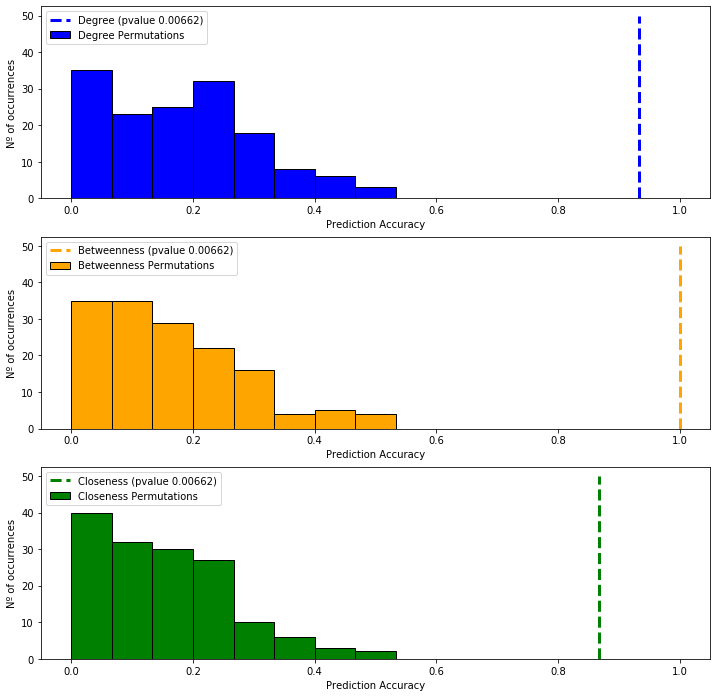

In [60]:
f, axes = plt.subplots(3, 1, figsize = (12,12))

Names = ['Degree', 'Betweenness', 'Closeness']
colors = ['blue','orange', 'green']
quadrant = [axes[0], axes[1], axes[2]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - Random Forests

In [61]:
CV = {}
PMs = {}
pvalue = {}

all_data = (degree_df, betw_df, closeness_df)
names = ('Degree', 'Betweenness', 'Closeness')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!


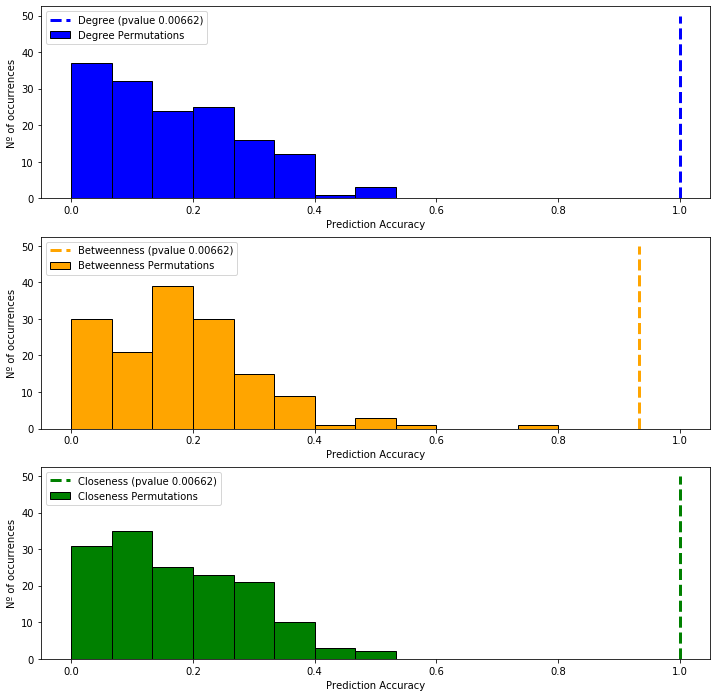

In [62]:
f, axes = plt.subplots(3, 1, figsize = (12,12))

Names = ['Degree', 'Betweenness', 'Closeness']
colors = ['blue','orange', 'green']
quadrant = [axes[0], axes[1], axes[2]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Full yeast dataset graph

In [63]:
formula_df = deformulator(yeast_df)
formula_df.index = yeast_df['Formula']
formula_df

,C,H,O,N,S,P
Formula,,,,,,
C12H24O2,12.0,24.0,2.0,0.0,0.0,0.0
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0
C4H10O3S3,4.0,10.0,3.0,0.0,3.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0
...,...,...,...,...,...,...
C13H18N15O6PS9,13.0,18.0,6.0,15.0,9.0,1.0
C21H30N5O4PS11,21.0,30.0,4.0,5.0,11.0,1.0
C23H33N3O6S11,23.0,33.0,6.0,3.0,11.0,0.0


In [64]:
Gr = nx.Graph()
Gr.add_nodes_from(formula_df.index)

In [65]:
BY2_groups = edge_assembler(formula_df,Gr)
inverse_weight_attributer(Gr)

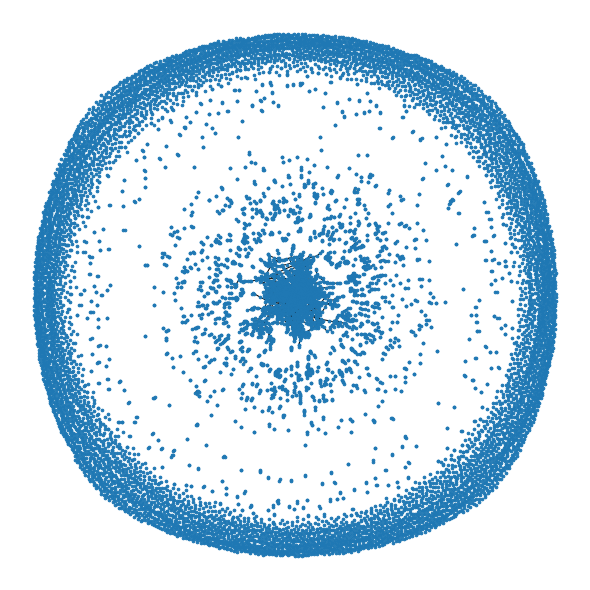

In [66]:
plt.figure(figsize=(8,8))
nx.draw(Gr, node_size=7)
plt.show()

In [67]:
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[1197,
 214,
 102,
 37,
 34,
 25,
 24,
 23,
 19,
 19,
 16,
 15,
 15,
 15,
 13,
 12,
 12,
 12,
 12,
 11]

In [68]:
BY2_groups

{'H2': 345.09999999999934,
 'CH2': 427.78333333333205,
 'CO2': 155.29999999999998,
 'O': 309.83333333333314,
 'CHOH': 254.8833333333334,
 'NCH': 177.30000000000004,
 'O(-NH)': 191.98333333333335,
 'OH': 65.33333333333334,
 'S': 27.0,
 'CONH': 1.5,
 'PO3H': 71.83333333333334,
 'NH3(-O)': 182.95000000000002,
 'SO3': 59.16666666666667,
 'CO': 226.21666666666673,
 'C2H2O': 192.56666666666666,
 'H2O': 248.1}

In [69]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

2936.8499999999976

'CONH' groups doesn't establish almost any connection, 'S' also establishes a low amount of connections, followed by 'SO3' and 'OH'.

### A lot more analysis with Average Size of Networks, Contributions of different groups to the Networks, Heat Diffusion, etc.

### To Do:

- Edit groups and see more groups in BRENDA - Done for now
- Use Group_influence - Kinda 50% done? Not great results
- Explain extensions made - Done
- Implement Shakespear Heat diffusion
- Ameliorate analysis overall - inclusion of average size of networks
- Try idea of induced subgraphs
- Better presentation especially on edge_assembler? Maybe implement something that you can just say the groups and the function will adapt accordingly - possible using formula_process function most likely, would it be worth the slight decrease in time (probable small in comparison with the time it takes).

### Old edge_assembler

In [70]:
def edge_assembler(formula_df, G):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges."""
    
    groups = ['H2','CH2','CO2','O','PH3','SH2','NH2','OH','SH','PH2','PO3H','NH3(-O)','SO3','CO']
    group_influence = dict.fromkeys(groups,0)
    
    for i in formula_df.index:
        node = formula_df.loc[i]
        
        #H2
        weight = edge_finder(G, formula_df, node, h=2)
        #print(weight)
        if weight != 0:
            group_influence['H2'] = group_influence['H2'] + (1/weight)

        #CH2
        weight = edge_finder(G, formula_df, node, c=1, h=2)
        if weight != 0:
            group_influence['CH2'] = group_influence['CH2'] + (1/weight)

        ######CO2
        weight = edge_finder(G, formula_df, node, c=1, o=2)
        if weight != 0:
            group_influence['CO2'] = group_influence['CO2'] + (1/weight)

        #O
        weight = edge_finder(G, formula_df, node, o=1)
        if weight != 0:
            group_influence['O'] = group_influence['O'] + (1/weight)

        ######PH3
        weight = edge_finder(G, formula_df, node, h=3, p=1)
        if weight != 0:
            group_influence['PH3'] = group_influence['PH3'] + (1/weight)

        ######SH2
        weight = edge_finder(G, formula_df, node, h=2, s=1)
        if weight != 0:
            group_influence['SH2'] = group_influence['SH2'] + (1/weight)

        #NH2
        weight = edge_finder(G, formula_df, node, h=2, n=1)
        if weight != 0:
            group_influence['NH2'] = group_influence['NH2'] + (1/weight)

        #OH
        weight = edge_finder(G, formula_df, node, h=1, o=1)
        if weight != 0:
            group_influence['OH'] = group_influence['OH'] + (1/weight)

        #SH
        weight = edge_finder(G, formula_df, node, h=1, s=1)
        if weight != 0:
            group_influence['SH'] = group_influence['SH'] + (1/weight)

        #PH2
        weight = edge_finder(G, formula_df, node, h=2, p=1)
        if weight != 0:
            group_influence['PH2'] = group_influence['PH2'] + (1/weight)
    
        #PO3(H)
        weight = edge_finder(G, formula_df, node, h=1, o=3, p=1)
        if weight != 0:
            group_influence['PO3H'] = group_influence['PO3H'] + (1/weight)

        #NH3-O
        weight = edge_finder(G, formula_df, node, h=3, o=-1, n=1)
        if weight != 0:
            group_influence['NH3(-O)'] = group_influence['NH3(-O)'] + (1/weight)

        #SO3
        weight = edge_finder(G, formula_df, node, h=0, o=3, s=1)
        if weight != 0:
            group_influence['SO3'] = group_influence['SO3'] + (1/weight)

        #CO
        weight = edge_finder(G, formula_df, node, c=1, o=1)
        if weight != 0:
            group_influence['CO'] = group_influence['CO'] + (1/weight)
                
    return group_influence